# SMART BIRDFEEDER: Birb.io

## A machine learning project

#### Jack Edney

### Day 1 Pretraining and evaluating MobileNetV3, evaluating data pipeline techniques

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
tf.__version__

'2.4.0'

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Importing the pretrained model:

In [139]:
from tensorflow.keras.applications import MobileNetV3Small
# using small version of mobilenetv3 as this is going to be used on a raspberry pi, and I wan't to use the most efficient architecture

In [37]:
def initialise_model(model):
    output = keras.layers.Dense(200, activation='softmax')(model.output)
    return keras.models.Model(inputs=model.input, outputs=output)
# run this everytime I want to initialise the pretrained model to the imagenet weights, with the required softmax classifier output

In [86]:
full_model = initialise_model(MobileNetV3Small(input_shape=(224, 224, 3), minimalistic=True, weights='imagenet', dropout_rate=0.2, include_top=False, pooling='max'))
# minimalistic may improve GPU performance, dropout should reduce overfitting

In [39]:
preprocess_fn = keras.applications.mobilenet_v3.preprocess_input

In [40]:
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 64, 64, 16)   432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 64, 64, 16)   64          Conv[0][0]                       
____________________________________________________________________________________________

### Displaying the images:

In [ ]:
PATH = "USBirbs/CUB_200_2011/CUB_200_2011"
# I am using the Caltech USDC 200 Bird image dataset to pretrain my model to recognise bird features

In [96]:
IMAGES = os.path.join(PATH, "images")

In [97]:
test_image = os.path.join(IMAGES, '001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg')

In [98]:
def imdisplay(file):
    if type(file) == str:
        plt.imshow(plt.imread(file))
    else:
        plt.imshow(file.reshape(224, 224, 3))
    plt.axis('off')
# This simple function displays the image if it is either a path to an image, or an array of rgb pixel values

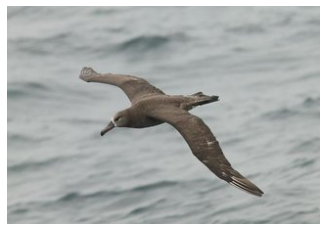

In [99]:
imdisplay(test_image)
# This is a raw image

In [100]:
from tensorflow.keras.preprocessing import image

In [101]:
def prepare_image(file):
    img = image.load_img(file, target_size=(224, 224))
    img_array = image.img_to_array(img)/255.
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_fn(img_array_expanded_dims)
# This function shows how the model sees the image, it can also be used to see what the model will categorise this image as

In [9]:
full_model = keras.models.Model(inputs=model.input, outputs=output)

In [102]:
preprocessed_image = prepare_image(test_image)

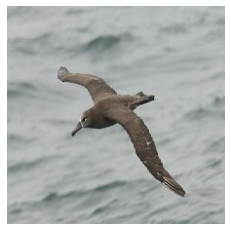

In [103]:
imdisplay(preprocessed_image)
# This is how the model sees the same image

### Preparing the model:

In [104]:
for layer in full_model.layers:
    layer.trainable=False
for layer in full_model.layers[:20]:
    layer.trainable=False
for layer in full_model.layers[20:]:
    layer.trainable=True
# Setting the first 20 layers to be untrainable to prevent losing key architecture features during early-training

In [105]:
full_model.summary()
# You can see this is a small CNN with only 1.2 million parameters

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 224, 224, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_5[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
____________________________________________________________________________________________

### Preparing and batching the images:

In [106]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [140]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_fn, validation_split=0.2)
# I'm using an ImageDataGenerator to batch and preprocess the image files before training

In [108]:
train_datagenerator = datagen.flow_from_directory(IMAGES,
                                                       target_size=(224,224),
                                                       color_mode='rgb',
                                                       batch_size=32,
                                                       class_mode='categorical',
                                                       subset='training',
                                                       shuffle=True)

Found 9465 images belonging to 200 classes.


In [109]:
valid_datagenerator = datagen.flow_from_directory(IMAGES,
                                                       target_size=(224,224),
                                                       color_mode='rgb',
                                                       batch_size=32,
                                                       class_mode='categorical',
                                                       subset='validation',
                                                       shuffle=True)

Found 2323 images belonging to 200 classes.


### Training, first try:

In [11]:
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
step_size_train = train_datagenerator.n//train_datagenerator.batch_size

In [29]:
full_model.fit(train_datagenerator,
               validation_data=valid_datagenerator,
              steps_per_epoch=step_size_train,
              epochs=10)
# First round of model training

Epoch 1/10
295/295 [==============================] - 71s 193ms/step - loss: 9.1696 - accuracy: 0.0102 - val_loss: 7.6349 - val_accuracy: 0.0220
Epoch 2/10
295/295 [==============================] - 44s 149ms/step - loss: 4.7104 - accuracy: 0.0544 - val_loss: 5.8100 - val_accuracy: 0.0400
Epoch 3/10
295/295 [==============================] - 44s 149ms/step - loss: 3.8151 - accuracy: 0.1365 - val_loss: 4.2572 - val_accuracy: 0.1300
Epoch 4/10
295/295 [==============================] - 44s 150ms/step - loss: 3.0576 - accuracy: 0.2503 - val_loss: 4.3478 - val_accuracy: 0.1360
Epoch 5/10
295/295 [==============================] - 44s 148ms/step - loss: 2.3630 - accuracy: 0.3826 - val_loss: 3.9002 - val_accuracy: 0.1821
Epoch 6/10
295/295 [==============================] - 44s 150ms/step - loss: 1.8902 - accuracy: 0.4963 - val_loss: 3.9016 - val_accuracy: 0.2286
Epoch 7/10
295/295 [==============================] - 44s 148ms/step - loss: 1.4766 - accuracy: 0.5801 - val_loss: 3.7495 - val_ac

In [32]:
for layer in full_model.layers:
    layer.trainable=True
# Now allowing the whole model to be trained

In [ ]:
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
# Reducing the learning rate to hone in optimal model parameter search

In [33]:
full_model.fit(train_datagenerator,
               validation_data=valid_datagenerator,
              steps_per_epoch=step_size_train,
              epochs=10)
# Second round of model training

Epoch 1/10
295/295 [==============================] - 47s 148ms/step - loss: 0.3097 - accuracy: 0.9153 - val_loss: 2.5442 - val_accuracy: 0.4585
Epoch 2/10
295/295 [==============================] - 42s 142ms/step - loss: 0.0999 - accuracy: 0.9799 - val_loss: 2.4640 - val_accuracy: 0.4916
Epoch 3/10
295/295 [==============================] - 42s 144ms/step - loss: 0.0555 - accuracy: 0.9919 - val_loss: 2.4551 - val_accuracy: 0.4946
Epoch 4/10
295/295 [==============================] - 42s 143ms/step - loss: 0.0359 - accuracy: 0.9958 - val_loss: 2.4907 - val_accuracy: 0.5084
Epoch 5/10
295/295 [==============================] - 42s 142ms/step - loss: 0.0267 - accuracy: 0.9966 - val_loss: 2.4916 - val_accuracy: 0.5067
Epoch 6/10
295/295 [==============================] - 43s 145ms/step - loss: 0.0249 - accuracy: 0.9958 - val_loss: 2.6107 - val_accuracy: 0.4933
Epoch 7/10
295/295 [==============================] - 42s 143ms/step - loss: 0.0281 - accuracy: 0.9949 - val_loss: 2.6627 - val_ac

The training ends with the validation accuracy hovvering around 50%. For a dataset containing 200 different categories, where many of them are undoubtedly quite similar, this is not a bad score. However, considering that the train accuracy ended at almost 100% we need to address the overfitting problem.

### Preparing and batching the images, second try:

In [123]:
datagen_manip = ImageDataGenerator(
                                rotation_range=15, 
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                brightness_range=(0.7, 1.3),
                                channel_shift_range=0.3,
                                shear_range=0.05, 
                                zoom_range=0.2,
                                horizontal_flip=False,
                                preprocessing_function=preprocess_fn,
                                validation_split=0.2)
# Using image augmentation to randomly augment the images before each epoch

In [124]:
train_datagenerator_manip = datagen_manip.flow_from_directory(IMAGES,
                                                       target_size=(224,224),
                                                       color_mode='rgb',
                                                       batch_size=32,
                                                       class_mode='categorical',
                                                       subset='training',
                                                       shuffle=True)

Found 9465 images belonging to 200 classes.


In [125]:
valid_datagenerator_manip = datagen_manip.flow_from_directory(IMAGES,
                                                       target_size=(224,224),
                                                       color_mode='rgb',
                                                       batch_size=32,
                                                       class_mode='categorical',
                                                       subset='validation',
                                                       shuffle=True)

Found 2323 images belonging to 200 classes.


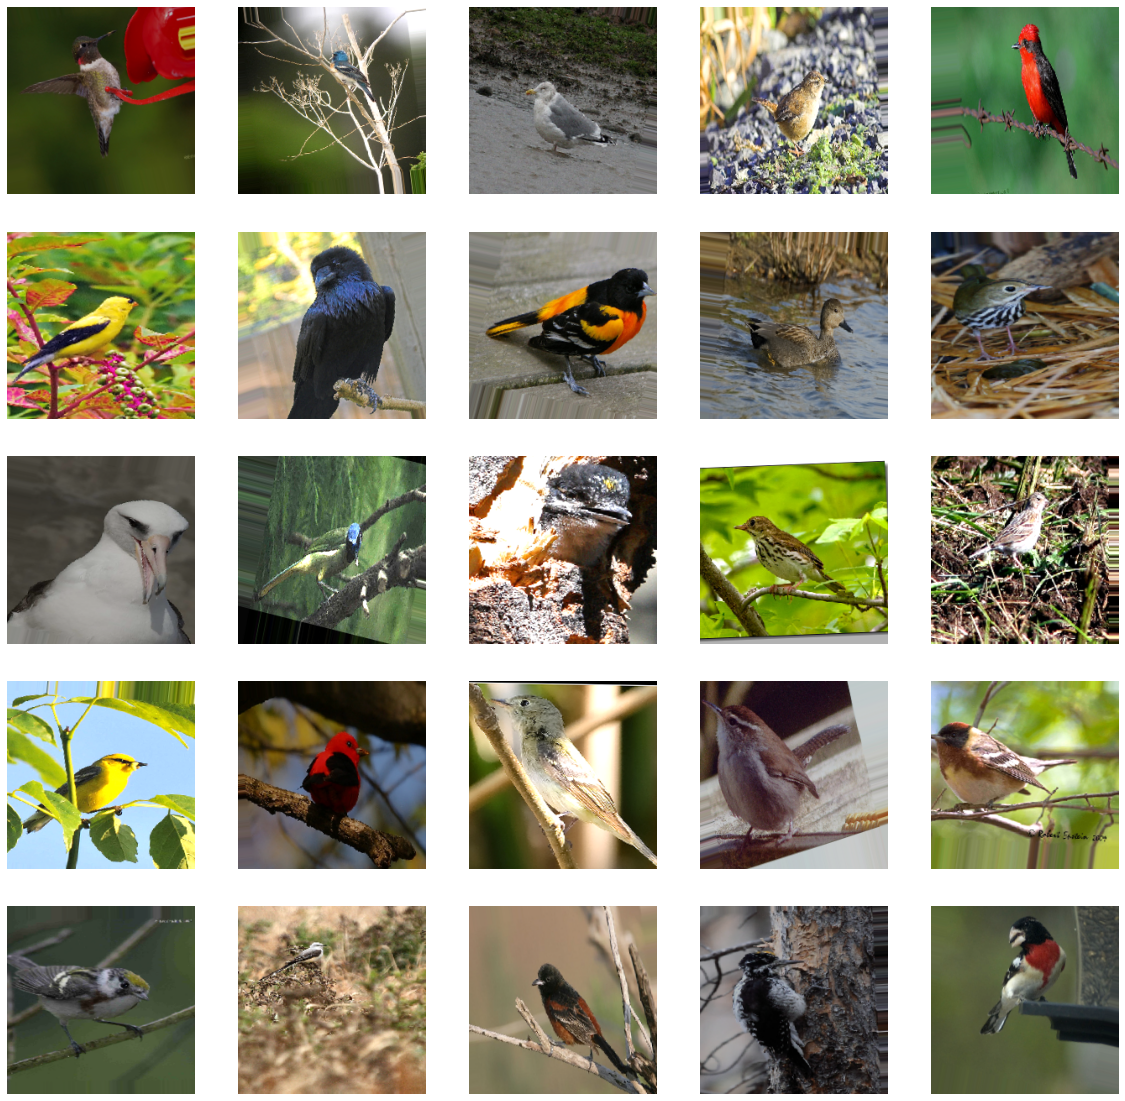

In [154]:
x,y = valid_datagenerator_manip.next()
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    image = x[i]
    imdisplay(image/255.)
plt.show()
# We can have a look at the augmentations, using augmented images is a great way to reduce overfitting, especially for CNNs

# You can see that even though the images are rotated, squeezed and the colour channels offset, we can still identify the key features of each bird

### Training, second try:

In [131]:
full_model = initialise_model(MobileNetV3Small(input_shape=(224, 224, 3), minimalistic=True, weights='imagenet', dropout_rate=0.2, include_top=False, pooling='max'))\
# Reinitializing the model, so that the weights are the imagenet weights

In [132]:
for layer in full_model.layers:
    layer.trainable=False
for layer in full_model.layers[:40]:
    layer.trainable=False
for layer in full_model.layers[40:]:
    layer.trainable=True

In [133]:
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [134]:
step_size_train = train_datagenerator.n//train_datagenerator.batch_size

In [135]:
full_model.fit(train_datagenerator_manip,
               validation_data=valid_datagenerator_manip,
              steps_per_epoch=step_size_train,
              epochs=10)

Epoch 1/10
295/295 [==============================] - 225s 749ms/step - loss: 9.3190 - accuracy: 0.0073 - val_loss: 7.9613 - val_accuracy: 0.0116
Epoch 2/10
295/295 [==============================] - 226s 767ms/step - loss: 4.9657 - accuracy: 0.0337 - val_loss: 5.6759 - val_accuracy: 0.0435
Epoch 3/10
295/295 [==============================] - 225s 764ms/step - loss: 4.0679 - accuracy: 0.1070 - val_loss: 5.2220 - val_accuracy: 0.0641
Epoch 4/10
295/295 [==============================] - 224s 761ms/step - loss: 3.3398 - accuracy: 0.2087 - val_loss: 3.8797 - val_accuracy: 0.1864
Epoch 5/10
295/295 [==============================] - 224s 761ms/step - loss: 2.7385 - accuracy: 0.3167 - val_loss: 4.1282 - val_accuracy: 0.1967
Epoch 6/10
295/295 [==============================] - 225s 764ms/step - loss: 2.3463 - accuracy: 0.3948 - val_loss: 4.1636 - val_accuracy: 0.2355
Epoch 7/10
295/295 [==============================] - 226s 765ms/step - loss: 2.0529 - accuracy: 0.4473 - val_loss: 3.9554 -

In [136]:
for layer in full_model.layers:
    layer.trainable=True

In [137]:
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

In [138]:
full_model.fit(train_datagenerator_manip,
               validation_data=valid_datagenerator_manip,
              steps_per_epoch=step_size_train,
              epochs=10)

Epoch 1/10
295/295 [==============================] - 237s 786ms/step - loss: 1.0360 - accuracy: 0.6990 - val_loss: 2.5444 - val_accuracy: 0.4163
Epoch 2/10
295/295 [==============================] - 229s 777ms/step - loss: 0.7812 - accuracy: 0.7634 - val_loss: 2.4147 - val_accuracy: 0.4171
Epoch 3/10
295/295 [==============================] - 235s 797ms/step - loss: 0.6781 - accuracy: 0.7968 - val_loss: 2.4311 - val_accuracy: 0.4387
Epoch 4/10
295/295 [==============================] - 229s 776ms/step - loss: 0.6153 - accuracy: 0.8100 - val_loss: 2.3568 - val_accuracy: 0.4589
Epoch 5/10
295/295 [==============================] - 219s 742ms/step - loss: 0.5586 - accuracy: 0.8306 - val_loss: 2.2283 - val_accuracy: 0.4709
Epoch 6/10
295/295 [==============================] - 221s 750ms/step - loss: 0.5188 - accuracy: 0.8435 - val_loss: 1.9869 - val_accuracy: 0.5123
Epoch 7/10
295/295 [==============================] - 219s 744ms/step - loss: 0.4442 - accuracy: 0.8649 - val_loss: 2.0631 -

In [142]:
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [143]:
full_model.fit(train_datagenerator_manip,
               validation_data=valid_datagenerator_manip,
              steps_per_epoch=step_size_train,
              epochs=5)

Epoch 1/5
295/295 [==============================] - 233s 776ms/step - loss: 0.2988 - accuracy: 0.9093 - val_loss: 1.9052 - val_accuracy: 0.5803
Epoch 2/5
295/295 [==============================] - 228s 773ms/step - loss: 0.2646 - accuracy: 0.9217 - val_loss: 1.7980 - val_accuracy: 0.5997
Epoch 3/5
295/295 [==============================] - 227s 769ms/step - loss: 0.2191 - accuracy: 0.9344 - val_loss: 1.8226 - val_accuracy: 0.6027
Epoch 4/5
295/295 [==============================] - 225s 764ms/step - loss: 0.2275 - accuracy: 0.9306 - val_loss: 1.8495 - val_accuracy: 0.6009
Epoch 5/5
295/295 [==============================] - 226s 767ms/step - loss: 0.2150 - accuracy: 0.9361 - val_loss: 1.8514 - val_accuracy: 0.5923


In [144]:
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [145]:
full_model.fit(train_datagenerator_manip,
               validation_data=valid_datagenerator_manip,
              steps_per_epoch=step_size_train,
              epochs=5)

Epoch 1/5
295/295 [==============================] - 234s 781ms/step - loss: 0.2107 - accuracy: 0.9374 - val_loss: 1.8935 - val_accuracy: 0.5962
Epoch 2/5
295/295 [==============================] - 226s 765ms/step - loss: 0.1901 - accuracy: 0.9435 - val_loss: 1.8735 - val_accuracy: 0.5979
Epoch 3/5
295/295 [==============================] - 226s 766ms/step - loss: 0.2049 - accuracy: 0.9377 - val_loss: 1.8611 - val_accuracy: 0.6027
Epoch 4/5
295/295 [==============================] - 233s 790ms/step - loss: 0.1801 - accuracy: 0.9471 - val_loss: 1.8518 - val_accuracy: 0.5962
Epoch 5/5
295/295 [==============================] - 248s 841ms/step - loss: 0.1857 - accuracy: 0.9422 - val_loss: 1.8738 - val_accuracy: 0.6078


The training ends with the validation accuracy hovvering around 60%. Which is a 10% improvement on the model without image augmentation, however, there is still overfitting.